# **Projeto 1 introdução a redes neurais**

------------------------------------------------------------------------------------------------------------

## Objetivo: 

Implementar uma rede MLP, em python, sem usar pacotes prontos (e.g., Pytorch, Tensorflow, etc.)
Com a rede implementada, desenvolver dois modelos: um para classificação e um para regressão.
Avaliar os hiperparâmetros dos modelos variando o número de camadas, número de neurônio e taxas (eta e momentum).

## Importanto as bibliotecas necessárias

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(
    style='darkgrid',
    context='notebook',
    rc={
        'axes.spines.top': False,
        'axes.spines.right': False
    }
)

## Funções de ativação 

A função linear retorna o próprio x

In [2]:
def linear(x): 
    return x 

A função degrau acima retorna 1 se x > 0 ou 0 caso contrário

In [3]:
def degrau(x): 
    return np.where(x >= 0, 1, 0) 

A função sigmoid logística retorna 
$$
f(x) = \frac{1}{1 + \exp(-x)}
$$

In [4]:
def sigmoid(x): 
    return 1 / (1 + np.exp(-x)) 

A derivada da função sigmoid retorna 

$$
f'(x) = f(x) \cdot (1 - f(x))
$$

In [5]:
def sigmoid_derivada(x): 
    return x * (1 - x)

A função tangente hiperbólica retorna a tangente hiperbólica do x

In [6]:
def tanh(x):
    return np.tanh(x)

A função relu retorna o máximo entre o X e 0

In [7]:
def relu(x): 
    return np.maximum(0, x)

A função softmax converte a saída padrão em uma distribuição de probabilidade, da forma: 
$$
f(y) = \frac{\exp(y)}{\sum_{k} \exp(y_k)}
$$

In [8]:
def softmax(x): 
    exp = np.exp(x - np.max(x))
    return exp / np.sum(exp, axis=-1, keepdims=True)

## Retropropagação

A retropropagação surgiu para resolver o problema de como atualizar os neurônios das camadas ocultas em redes neurais. Em redes profundas, esses neurônios não têm erros diretamente observáveis como na camada de saída. O objetivo da retropropagação é calcular esses erros e ajustar os pesos das camadas ocultas utilizando o método de gradiente descendente, permitindo que redes com múltiplas camadas aprendam de forma eficiente. As contas da retropropagação envolvem o cálculo do gradiente da função de erro em relação aos pesos, ajustando-os de forma iterativa para minimizar a diferença entre as saídas desejadas e as reais. Esses cálculos incluem a atualização dos pesos na camada de saída, com base no erro direto, e nas camadas ocultas, com base nos erros propagados pela rede, até a camada de entrada. O processo é feito usando o gradiente local, o qual depende da função de ativação de cada neurônio, garantindo que o erro seja distribuído corretamente entre as camadas da rede.

### A fórmula para a atualização dos pesos de um neurônio, é dada por:
$$
\Delta w_{kj} = \eta \cdot \delta_k \cdot x_j
$$

- Onde: 
    - $\eta$ é a taxa de aprendizado
    - $\delta_k$ é o gradiente local do neurônio $k$
    - $x_j$ é a saída do neurônio anterior $j$ (entrada para o neurônio $k$)

### O cálculo do gradiente local ($\delta_k$) é dado por dois casos: 

#### Neurônio de saída: 
$
\delta_k = e_k \cdot f'(v_k)
$
- Onde:
  - $\delta_k$: Gradiente local do neurônio $k$
  - $e_k$: Erro no neurônio de saída
  - $f'(v_k)$: Derivada da função de ativação com relação ao estado interno $v_k$


#### Caso 2: Neurônio oculto: 
$
\delta_j = f'(v_j) \cdot \sum_k \delta_k \cdot w_{kj}
$

- Onde:
  - $\delta_j$: Gradiente local do neurônio $j$ da camada oculta
  - $f'(v_j)$: Derivada da função de ativação com relação ao estado interno $v_j$
  - $\sum_k$: Soma sobre todos os neurônios $k$ da camada seguinte
  - $\delta_k$: Gradiente local do neurônio $k$ da camada seguinte
  - $w_{kj}$: Peso entre o neurônio $j$ da camada oculta e o neurônio $k$ da camada seguinte



### A fórmula de erro quadrático médio ou MSE, é dada por: 

$$
E(n) = \frac{1}{2} \sum_{k} \left( d_k(n) - y_k(n) \right)^2
$$

Onde: 
- $E(n)$ é a função de erro na época $n$.
- $d_k(n)$ é o valor desejado para o neurônio $k$ na época $n$.
- $y_k(n)$ é o valor atual da saída do neurônio $k$ na época $n$.
- A soma é realizada sobre todos os neurônios $k$ da camada de saída.

### Feedfoward e Feedback 


O algoritmo de retropropagação opera em duas fases principais. Na fase de feedforward, os dados de entrada percorrem a rede camada por camada até a saída, produzindo as previsões. Já na fase de feedback, os erros calculados na saída são propagados de volta, ajustando os pesos camada a camada. Esse processo possibilita calcular o gradiente dos neurônios ocultos e atualizar seus pesos.

### Pseudocódigo 

- **Inicialização**: Configure os hiperparâmetros (taxa de aprendizado, número máximo de épocas, etc.) e inicialize os pesos da rede.
- **Treinamento**: Repita os passos abaixo até que o erro seja menor ou igual à tolerância definida ou até atingir o número máximo de épocas:
   - Aplique um padrão de entrada $x_i$ e o respectivo vetor de saída desejado $d_i$.
   - Realize a **propagação do sinal** (*feedforward*) da entrada até a saída.
   - Execute a **retropropagação dos erros** da saída para as camadas anteriores.
   - Atualize os pesos da rede com base nos gradientes calculados.
   - Retorne ao passo inicial para o próximo padrão de entrada.

### Implementação 

In [9]:
# Inicializando o momentum acumulado  
momentum_acumulado = None 

def retropropagação(X, y, pesos, bias, taxa_de_aprendizado, momentum): 
    """
    Função de retropropagação com feedforward e backpropagation
    
    Parâmetros:
    X: matriz de entradas (tamanho: número de amostras x número de características)
    y: vetor de saídas (tamanho: número de amostras)
    pesos: pesos da rede (incluindo pesos das camadas)
    bias: valores de bias das camadas
    taxa_aprendizado: taxa de aprendizado (eta)
    momentum: fator de momentum
    
    Retorna:
    pesos atualizados e bias ajustado
    """
    global momentum_acumulado

    # Inicializando o momentum acumulado se necessário (apenas na primeira execução)

    if momentum_acumulado is None: 
        momentum_acumulado = [np.zeros_like(peso) for peso in pesos] # Inicializa o momentum com o mesmo formato dos pesos

    #----------------------------------------------------------Feedforward---------------------------------------------------------------------- 
    camada = X # Dados de entrada X
    ativações = [X] # Lista que armazena as ativações, começando com a entrada
    lista_peso = [] # lista que armazena o peso de cada camada


    for peso, bias in zip(pesos, bias): 
        w = np.dot(camada, peso) + bias # Calcula o w da camada
        lista_peso.append(w) # Armazena na lista de pesos
        camada = sigmoid(w) #Aplicando a função de ativação sigmoid  
        ativações.append(camada) # Armazenando a ativação da camada 

    #----------------------------------------------------------Backpropagation------------------------------------------------------------------
    # Calculo do erro na camada de saída 
    gradiente = (ativações[-1] - y) * sigmoid_derivada(ativações[-1]) # Erro na camada de saída
    gradiente_w = [np.dot(ativações[-2].T, gradiente)] # Gradiente dos pesos da camada de saída
    gradiente_bias = [np.sum(gradiente, axis=0, keepdims=True)] # Gradiente dos bias da camada de saída

    # Calculando os gradientes para as camadas ocultas
    for camada in range(2, len(pesos) + 1):  
        w = lista_peso[-camada] # Obtém os pesos da camada atual na ordem inversa (da saída para a entrada)
        sig = sigmoid_derivada(sigmoid(w)) # Derivada da funcao de ativação sigmoid
        gradiente = np.dot(gradiente, pesos[-camada + 1].T) * sig # Propagando o erro
        gradiente_w.insert(0, np.dot(ativações[-camada - 1].T, gradiente)) # Gradiente dos pesos 
        gradiente_bias.insert(0, np.sum(gradiente, axis=0, keepdims=True)) # Gradiente dos vieses

    # Atualizando pesos e bias com momentum
    for i in range(len(pesos)): 
        # Atualiza o momentum acumulado
        momentum_acumulado[i] = momentum * momentum_acumulado[i] + gradiente_w[i] # Acumula o momentum
        pesos[i] -= taxa_de_aprendizado * momentum_acumulado[i] # Atualiza os pesos com o momentum acumulado
        bias[i] -= taxa_de_aprendizado * gradiente_bias[i] # Atualiza o bias

    return pesos, bias # Retorna os pesos e o bias ajustado

## Inicialização dos pesos

In [10]:
def inicializar_pesos(tamanho_camadas): 
    """
    Inicializa os pesos e os bias de uma rede neural   
    
    Parâmetros: 
    tamanho_camadas: contém o número de neurônios em cada camada da rede
    
    Retorna: 
    pesos: lista de matrizes de pesos entre cada camada
    bias: lista de vetores de bias para cada camada
    """
    # Listas para armazenar os pesos e bias de cada camada
    pesos = []  # Lista para armazenar os pesos
    bias = []   # Lista para armazenar os bias

    for i in range(len(tamanho_camadas) - 1): 
        camada_entrada = tamanho_camadas[i]
        camada_saida = tamanho_camadas[i + 1]

        # Inicializa pesos aleatórios 
        peso = np.random.randn(camada_entrada, camada_saida) 
        pesos.append(peso)  # Adiciona na lista de pesos

        # Inicializa os bias de forma aleatória 
        bias_camada = np.random.randn(1, camada_saida)
        bias.append(bias_camada)  # Adiciona na lista de bias

    return pesos, bias


## Treinamento

In [11]:
def treinamento(X_treino, y_treino, arquitetura, taxa_de_aprendizado, momentum, epocas): 
    """ 
    Parâmetros: 
    - X_treino: Matriz de entradas de treinamento    
    - y_treino: Vetor de saídas de treinamento
    - arquitetura: Lista com o número de neurônios por camada
    - taxa_de_aprendizado: Taxa de aprendizado (eta)
    - momentum: Fator de momentum
    - epocas: Número de épocas para treinamento
    
    Retorna: 
    - pesos: Pesos treinados pela rede
    - bias: Bias treinados pela rede
    - erros: Lista contendo o erro por época
    """

    # Inicializar pesos e bias
    pesos, bias = inicializar_pesos(arquitetura)

    erros = []  # Lista para armazenar os erros quadráticos médios (MSE)

    # Loop de treinamento
    for epoca in range(epocas): 
        # Atualizar pesos e bias com retropropagação
        pesos, bias = retropropagação(X_treino, y_treino, pesos, bias, taxa_de_aprendizado, momentum)

        # Calcular o erro 
        camada_de_saida = X_treino
        for peso, bias_camada in zip(pesos, bias): 
            camada_de_saida = sigmoid(np.dot(camada_de_saida, peso) + bias_camada)  # Feedforward

        erro = np.mean((y_treino - camada_de_saida) ** 2)  # Erro quadrático médio (MSE)
        erros.append(erro)  # Armazena o erro da época

    return pesos, bias, erros

## Classe MLP

In [12]:
class MLP: 
    def __init__(self, tamanho_camadas, taxa_de_aprendizado, momentum): 
        """
        Inicializa a rede neural MLP
        
        Parâmetros:
        tamanho_camadas: lista com o número de neurônios em cada camada
        taxa_de_aprendizado: taxa de aprendizado (eta)
        momentum: fator de momentum
        """
        self.tamanho_camadas = tamanho_camadas
        self.taxa_de_aprendizado = taxa_de_aprendizado
        self.momentum = momentum
    
        self.pesos, self.bias = inicializar_pesos(tamanho_camadas)


    def treinar(self, X_treino, y_treino, epocas): 
        """
        Treina o modelo usando retropropagação
        
        Parâmetros:
        X_treino: matriz de entradas de treinamento
        y_treino: vetor de saídas de treinamento
        epocas: número de épocas para treinamento
        
        Retorna:
        pesos: pesos treinados pela rede
        bias: bias treinados pela rede
        erros: lista de erros quadráticos médios por época
        """ 
        # Chamda a função de treinamento
        pesos, bias, erros =  treinamento(X_treino, y_treino, self.tamanho_camadas, self.taxa_de_aprendizado, self.momentum, epocas)
        # Atualiza os pesos e bias da rede
        self.pesos = pesos  
        self.bias = bias
        
        return pesos, bias, erros
    
    def prever(self, X): 
        """
        Realiza a previsão usando a rede neural MLP
        
        Parâmetros:
        X: matriz de entradas para previsão
        
        Retorna:
        y_pred: previsões feitas pela rede 
        """
        for peso, bias in zip(self.pesos, self.bias): 
            camada_de_entrada = sigmoid(np.dot(camada_de_entrada, peso) + bias)  # Feedforward

        return camada_de_entrada  # Retorna as probabilidades 


## Dataset e preparação dos dados

### O Dataset Iris

O Dataset é composto por 150 amostras de flores de três espécies de íris (Iris setosa, Iris versicolor e Iris virginica), com 4 características medidas: comprimento e largura das sépalas e pétalas. É amplamente utilizado para problemas de classificação, pois suas classes são bem distribuídas e as características são simples de interpretar. A escolha desse dataset se deve à sua simplicidade, tamanho moderado e equilíbrio entre as classes, o que o torna ideal para testar diferentes algoritmos de classificação.

### `train_test_split`
A função é uma ferramenta para dividir um conjunto de dados em dois subconjuntos: treinamento e teste.Ela permite que os dados sejam aleatoriamente separados, garantindo que o modelo seja treinado em uma parte dos dados e avaliado em outra, a função também permite definir a proporção da divisão.

### `StandardScaler`


A função é uma ferramenta usada para normalizar os dados, subtraindo a média e dividindo pelo desvio padrão. Esse processo transforma as características para terem média zero e desvio padrão igual a um.

### `accuracy_score`
A função calcula a acurácia de um modelo de classificação. Ele compara as previsões feitas pelo modelo com os valores reais do conjunto de dados, retornando a proporção de acertos. Essa métrica varia de 0 a 1, onde 1 significa 100% de acertos.

###  `PCA`
É uma técnica que reduz a dimensionalidade dos dados, mantendo a maior parte da variação. Ele transforma as variáveis originais em novos eixos, chamados componentes principais. O PCA é útil para simplificar a análise de dados e melhorar a visualização.

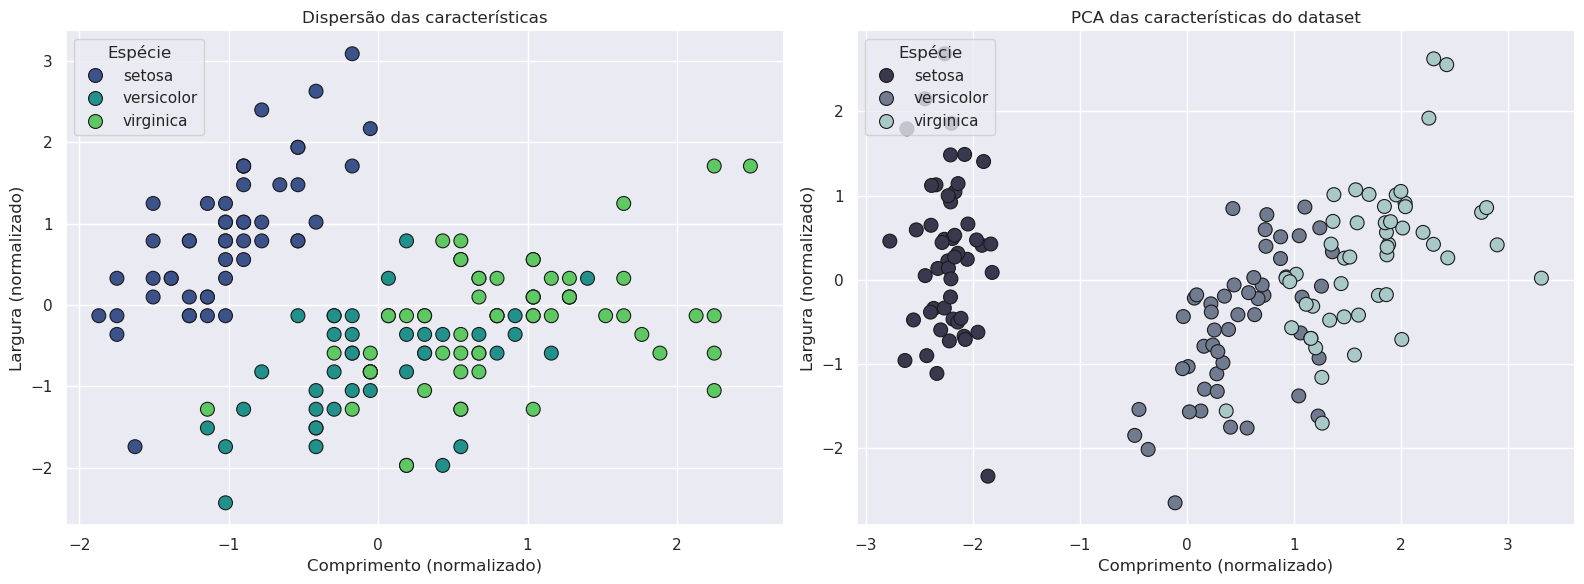

<Figure size 2000x2000 with 0 Axes>

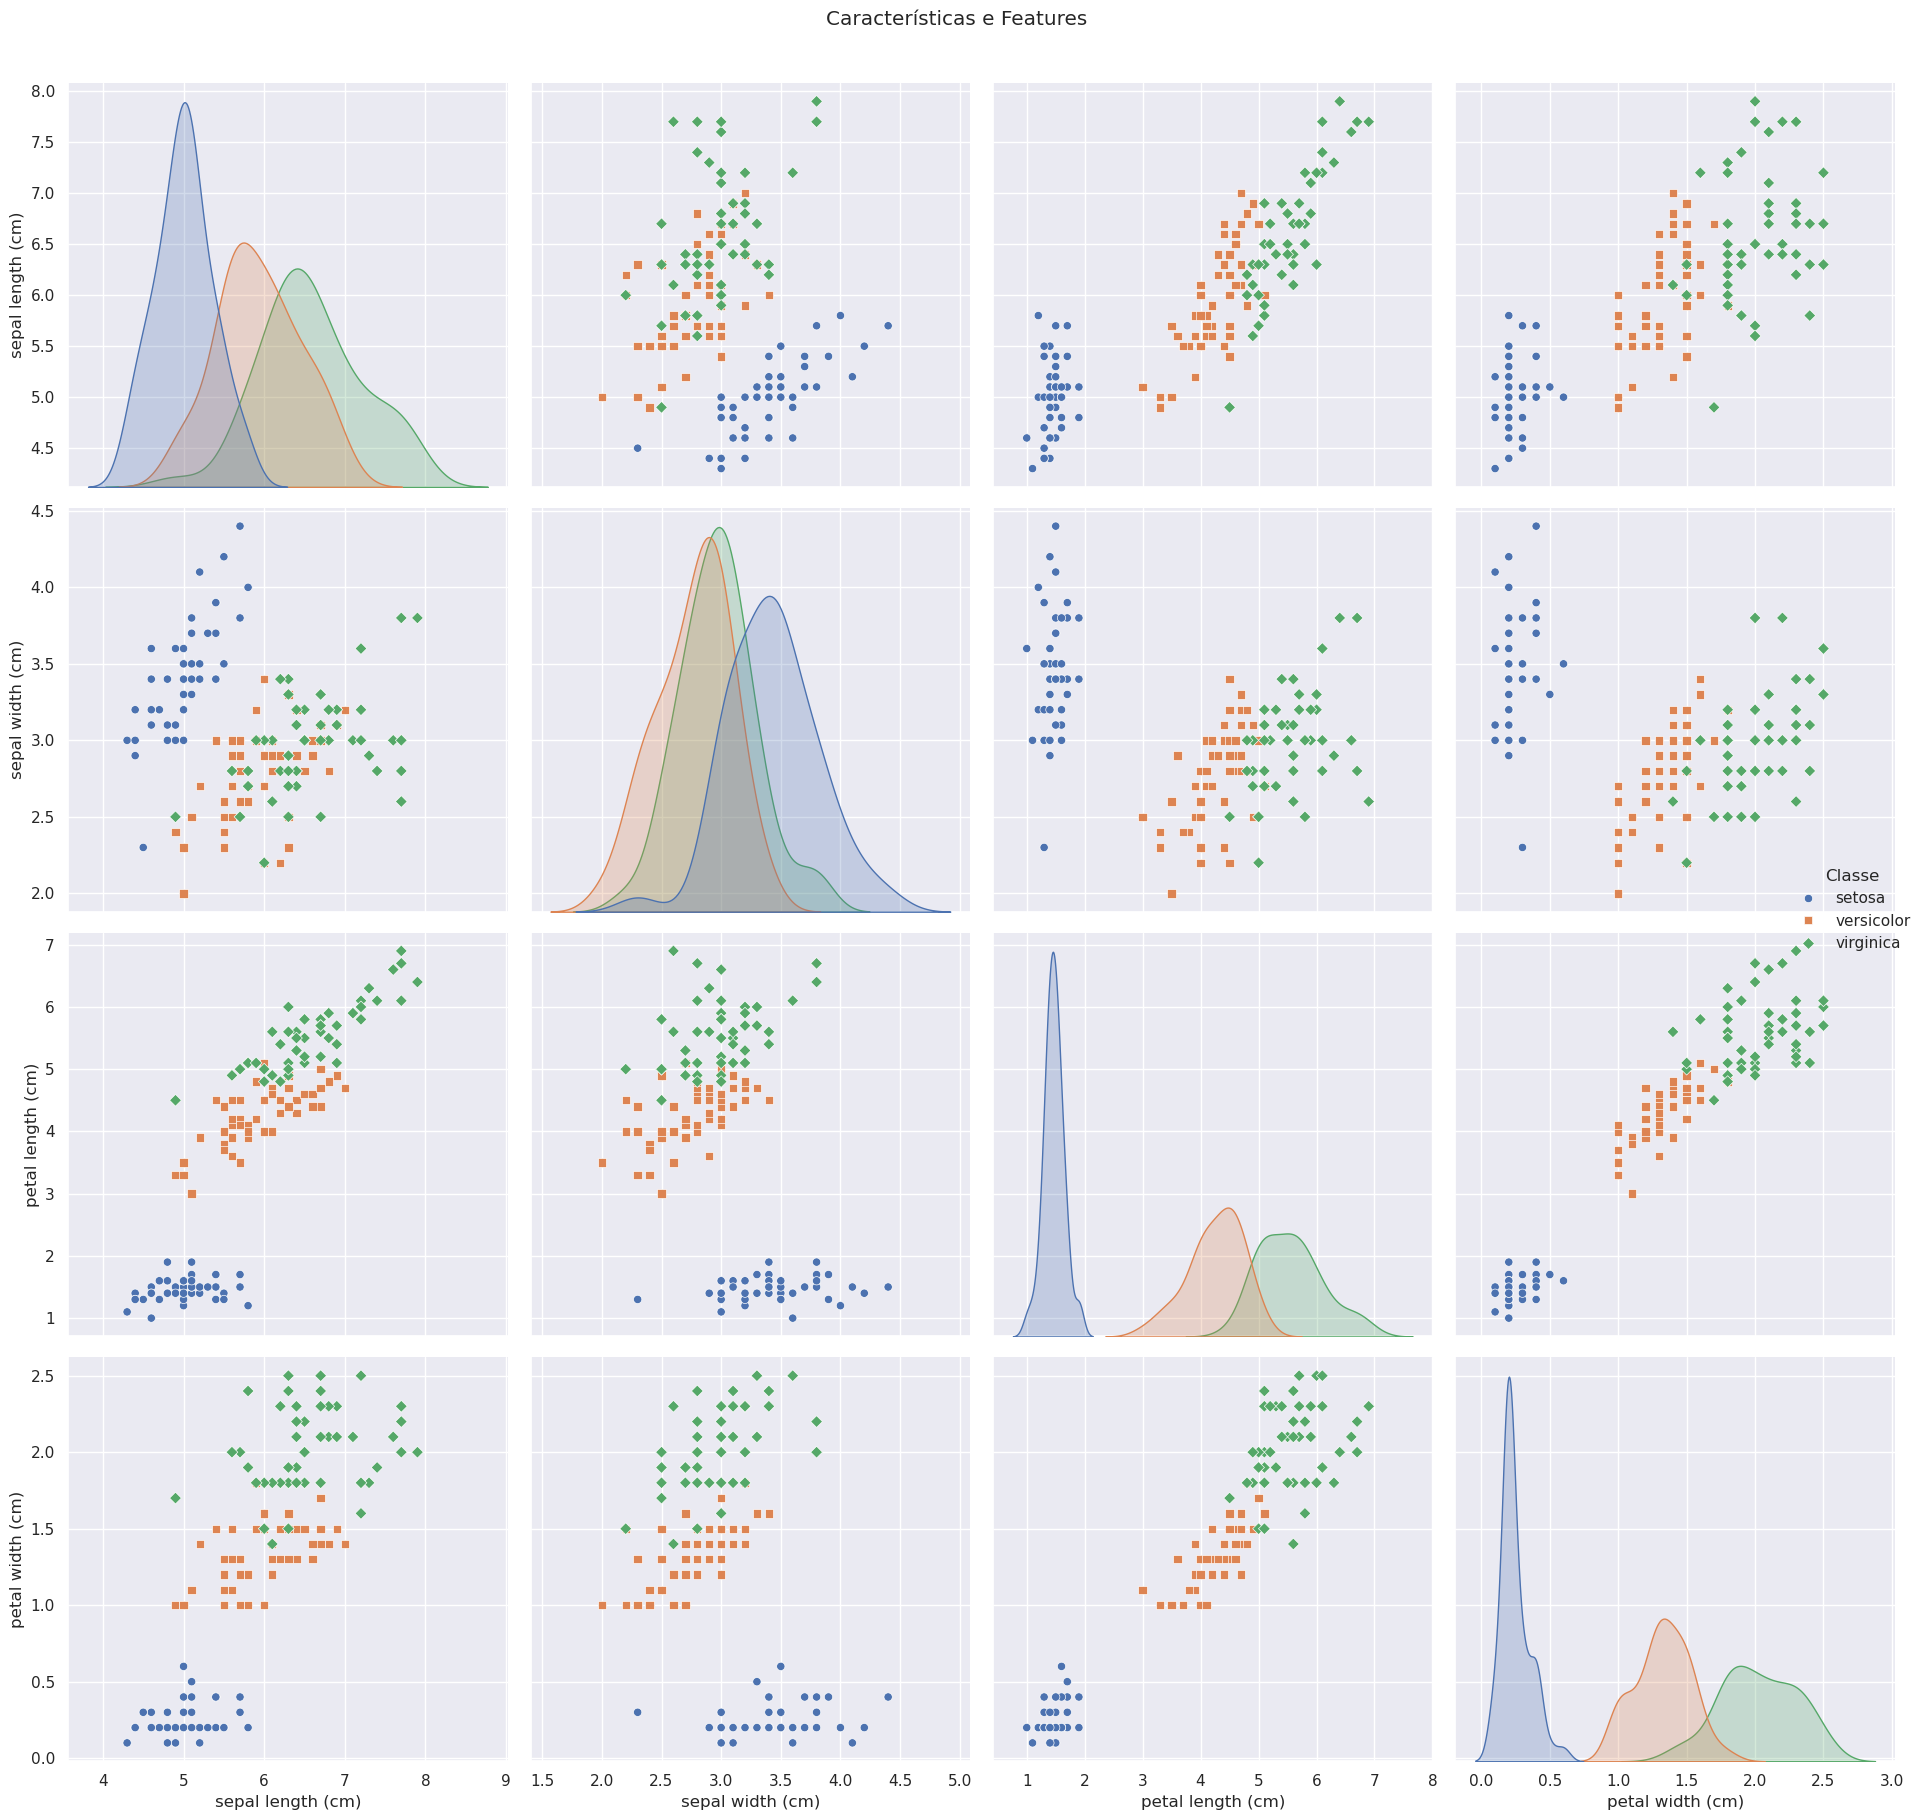

In [13]:
from sklearn.datasets import load_iris # Importando o Dataset 
from sklearn.model_selection import train_test_split # Importando train_test_split
from sklearn.preprocessing import StandardScaler # Importando StandardScaler
from sklearn.metrics import accuracy_score # Importando accuracy_score
from sklearn.decomposition import PCA # Importando PCA


# Carregar o dataset Iris
iris = load_iris()
X = iris.data  # features
y = iris.target  # target
features = iris.feature_names

# Normalizando os dados usando o StandardScaler
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)

# Nomes das classes
y_nomes = [iris.target_names[i] for i in y]

# Visualização dos dados
_, plot = plt.subplots(1,2, figsize=(16,6))
sns.scatterplot(x=X_normalizado[:, 0], y=X_normalizado[:, 1], hue=y_nomes, palette="viridis", s=100, edgecolor='k', ax=plot[0])
plot[0].set_title('Dispersão das características')
plot[0].set_xlabel('Comprimento (normalizado)')
plot[0].set_ylabel('Largura (normalizado)')
plot[0].legend(title='Espécie', loc='upper left')

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalizado)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_nomes, palette="bone", s=100, edgecolor='k', ax=plot[1])
plot[1].set_title('PCA das características do dataset')
plot[1].set_xlabel('Comprimento (normalizado)')
plot[1].set_ylabel('Largura (normalizado)')
plot[1].legend(title='Espécie', loc='upper left')
plt.tight_layout()

plt.figure(figsize=(20, 20))
df_features = pd.DataFrame(X, columns=features)
df_features['Classe'] = y_nomes
sns.pairplot(df_features, hue='Classe', palette='deep',  markers=["o", "s", "D"], height=4.5)
plt.suptitle('Características e Features',  y=1.01)
plt.tight_layout()

## Classificação